<a href="https://colab.research.google.com/github/filetando/AvantiMachineLearning/blob/main/segmentacao_em_ambientes_naturais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Instalar bibliotecas e baixar o dataset do kaggle

In [2]:
!pip install opendatasets
!pip install pandas
!pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 9.3 MB/s eta 0:00:00


Código novo até aqui

In [18]:
import os
import pandas as pd
from PIL import Image, ImageOps
import opendatasets as od
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import imagehash
import hashlib
import numpy as np
from collections import defaultdict

In [4]:
od.download("https://www.kaggle.com/datasets/carlolepelaars/camvid")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: lucasfileto
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/carlolepelaars/camvid


100%|██████████| 575M/575M [00:06<00:00, 86.3MB/s]


# 2. Verificação da quantidade de imagens e máscaras por pasta

In [5]:
dir_test = "/content/camvid/CamVid/test"
dir_test_labels = "/content/camvid/CamVid/test_labels"
dir_train = "/content/camvid/CamVid/train"
dir_train_labels = "/content/camvid/CamVid/train_labels"
dir_val = "/content/camvid/CamVid/val"
dir_val_labels = "/content/camvid/CamVid/val_labels"

dir_test_num = len(os.listdir(dir_test))
dir_test_labels_num = len(os.listdir(dir_test_labels))
dir_train_num = len(os.listdir(dir_train))
dir_train_labels_num = len(os.listdir(dir_train_labels))
dir_val_num = len(os.listdir(dir_val))
dir_val_labels_num = len(os.listdir(dir_val_labels))

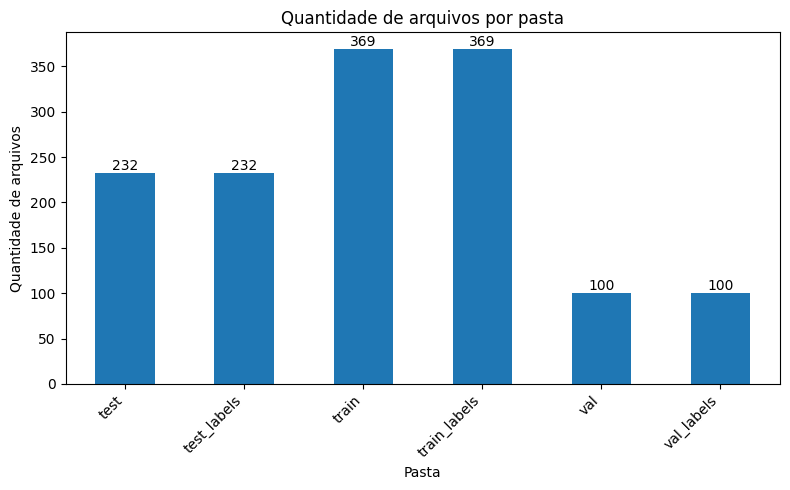

In [8]:
# Criando DataFrame
data = {
    'Quantidade de arquivos': [dir_test_num, dir_test_labels_num, dir_train_num, dir_train_labels_num, dir_val_num, dir_val_labels_num]
}
index = ['test', 'test_labels', 'train', 'train_labels', 'val', 'val_labels']
df = pd.DataFrame(data, index=index)

# Definindo cores por grupo
colors = ['skyblue', 'skyblue', 'lightcoral', 'lightcoral', 'lightgreen', 'lightgreen']

# Criando gráfico de barras
plt.figure(figsize=(8, 5))
ax = df['Quantidade de arquivos'].plot(kind='bar', legend=False) # Apply colors to the Series
plt.title('Quantidade de arquivos por pasta')
plt.xlabel('Pasta')
plt.ylabel('Quantidade de arquivos')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Adicionando valores nas barras
for container in ax.containers:
    ax.bar_label(container)

plt.show()

# 3. Verificando formato dos arquivos

In [9]:
def verificar_formato(dir):
  formatos = {}
  erros = []

  for arquivo in os.listdir(dir):
    caminho_completo = os.path.join(dir, arquivo)

    if os.path.isdir(caminho_completo):
      continue

    try:
      img = Image.open(caminho_completo)
      formato = img.format

      if formato in formatos:
        formatos[formato] += 1
      else:
        formatos[formato] = 1

    except Exception as e:
      erros.append(f'Erro ao abrir {arquivo}: {e}')

  return formatos,erros

In [10]:
def verificar_formato(dir):
  formatos = {}
  erros = []

  for arquivo in os.listdir(dir):
    caminho_completo = os.path.join(dir, arquivo)

    if os.path.isdir(caminho_completo):
      continue

    try:
      img = Image.open(caminho_completo)
      formato = img.format

      if formato in formatos:
        formatos[formato] += 1
      else:
        formatos[formato] = 1

    except Exception as e:
      erros.append(f'Erro ao abrir {arquivo}: {e}')

  return formatos,erros

def processar_diretorios_para_tabela(diretorios):
    todos_formatos = {}
    todos_erros = []

    for nome_diretorio, caminho_diretorio in diretorios.items():
        formatos, erros = verificar_formato(caminho_diretorio)
        todos_erros.extend(erros)

        for formato, quantidade in formatos.items():
            if nome_diretorio not in todos_formatos:
                todos_formatos[nome_diretorio] = {}
            todos_formatos[nome_diretorio][formato] = quantidade

    if todos_erros:
        print('Arquivos com erro:')
        for erro in todos_erros:
            print(erro)

    if todos_formatos:
        df_formatos = pd.DataFrame(todos_formatos).fillna(0).T
        df_formatos['Total'] = df_formatos.sum(axis=1)
        print("Formatos de Arquivo por Pasta")
        display(df_formatos)


diretorios = {
    'test': dir_test,
    'test_labels': dir_test_labels,
    'train': dir_train,
    'train_labels': dir_train_labels,
    'val': dir_val,
    'val_labels': dir_val_labels
}

processar_diretorios_para_tabela(diretorios)

Formatos de Arquivo por Pasta


,PNG,Total
test,232,232
test_labels,232,232
train,369,369
train_labels,369,369
val,100,100
val_labels,100,100


# 5. Explorando o arquivo `class_dict.csv`

In [11]:
caminho_class_dict = "/content/camvid/CamVid/class_dict.csv"

try:
    df_class_dict = pd.read_csv(caminho_class_dict)
    print(f"Conteúdo do arquivo: {caminho_class_dict}")
    display(df_class_dict)
except FileNotFoundError:
    print(f"Erro: O arquivo {caminho_class_dict} não foi encontrado.")
except Exception as e:
    print(f"Ocorreu um erro ao ler o arquivo {caminho_class_dict}: {e}")

Conteúdo do arquivo: /content/camvid/CamVid/class_dict.csv


,name,r,g,b
0,Animal,64,128,64
1,Archway,192,0,128
2,Bicyclist,0,128,192
3,Bridge,0,128,64
4,Building,128,0,0
5,Car,64,0,128
6,CartLuggagePram,64,0,192
7,Child,192,128,64
8,Column_Pole,192,192,128
9,Fence,64,64,128


# 6. Verificação de valores ausentes

In [12]:
# Confirmar se mantém

# Verificar valores ausentes no DataFrame df_class_dict
valores_ausentes = df_class_dict.isnull().sum()

print("Valores ausentes no DataFrame df_class_dict:")
display(valores_ausentes)

Valores ausentes no DataFrame df_class_dict:


,0
name,0
r,0
g,0
b,0


# 7. Verificando inconsistência nas imagens

In [13]:
def verificar_dimensoes_imagens_df(diretorio):
    dimensoes_contagem = {}
    erros_abrir = 0

    arquivos = os.listdir(diretorio)
    if not arquivos:
        return {'diretorio': diretorio}

    # Verificar as dimensões de todas as imagens
    for arquivo in arquivos:
        caminho_completo = os.path.join(diretorio, arquivo)
        if os.path.isdir(caminho_completo):
            continue
        try:
            with Image.open(caminho_completo) as img:
                dimensao = img.size
                if dimensao in dimensoes_contagem:
                    dimensoes_contagem[dimensao] += 1
                else:
                    dimensoes_contagem[dimensao] = 1
        except Exception as e:
             erros_abrir += 1

    return {'diretorio': diretorio, **dimensoes_contagem}


# Coletar informações de dimensões de todos os diretórios de imagens e máscaras
print("Verificando dimensões das imagens e máscaras:")

resultados_dimensoes = []
resultados_dimensoes.append(verificar_dimensoes_imagens_df(dir_test))
resultados_dimensoes.append(verificar_dimensoes_imagens_df(dir_test_labels))
resultados_dimensoes.append(verificar_dimensoes_imagens_df(dir_train))
resultados_dimensoes.append(verificar_dimensoes_imagens_df(dir_train_labels))
resultados_dimensoes.append(verificar_dimensoes_imagens_df(dir_val))
resultados_dimensoes.append(verificar_dimensoes_imagens_df(dir_val_labels))

# Criar DataFrame a partir dos resultados coletados
df_dimensoes = pd.DataFrame(resultados_dimensoes)

# Extrair apenas o último nome do diretório
df_dimensoes['Nome_do_diretorio'] = df_dimensoes['diretorio'].apply(lambda x: os.path.basename(x))

# Remover a coluna original 'diretorio'
df_dimensoes = df_dimensoes.drop('diretorio', axis=1)

# Reordenar as colunas para colocar 'Nome_do_diretorio' como a primeira coluna
cols = ['Nome_do_diretorio'] + [col for col in df_dimensoes.columns if col != 'Nome_do_diretorio']
df_dimensoes = df_dimensoes[cols]

print("\nResumo das dimensões das imagens por diretório:")
display(df_dimensoes)

Verificando dimensões das imagens e máscaras:

Resumo das dimensões das imagens por diretório:


,Nome_do_diretorio,"(960, 720)"
0,test,232
1,test_labels,232
2,train,369
3,train_labels,369
4,val,100
5,val_labels,100



Coluna de dimensão encontrada: (960, 720)


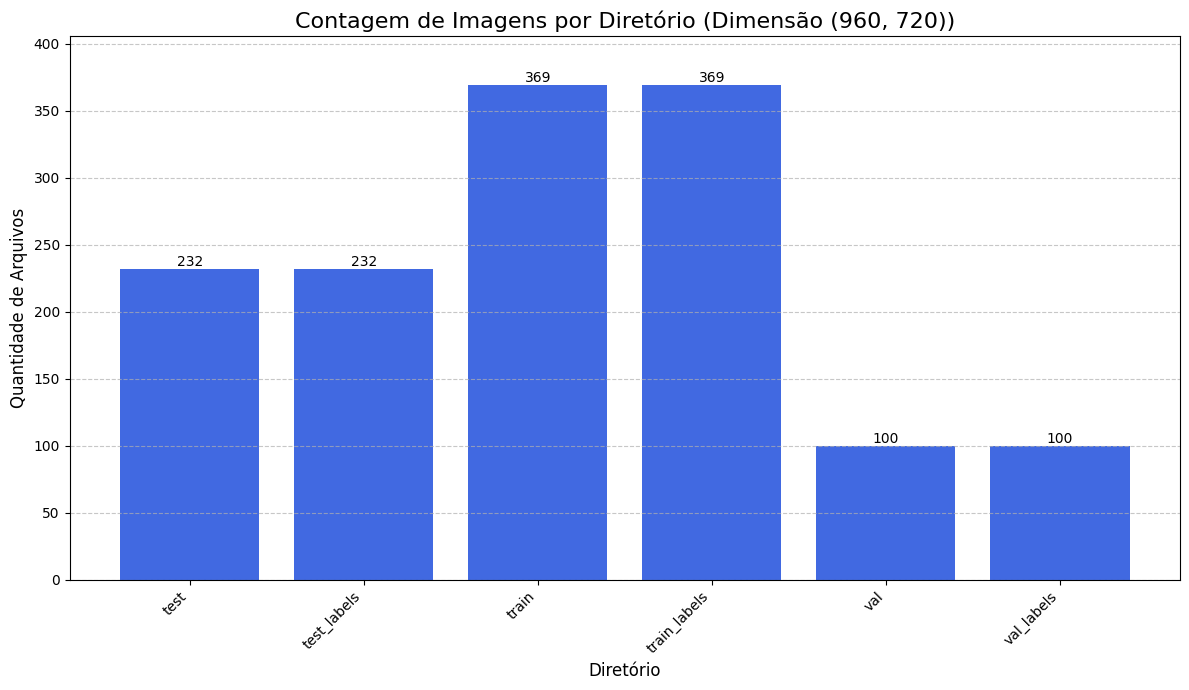

In [14]:
 # Encontrar a coluna de dimensão dinamicamente
dimension_column = None
for col in df_dimensoes.columns:
    # A coluna de dimensão será uma tupla (ex: (960, 720))
    if isinstance(col, tuple):
        dimension_column = col
        print(f"\nColuna de dimensão encontrada: {dimension_column}")
        break # Para o loop assim que encontrar a primeira

# Gerar o gráfico se a coluna foi encontrada
if dimension_column is not None:
    plt.figure(figsize=(12, 7))

    # Cria o gráfico de barras usando a coluna encontrada
    bars = plt.bar(
        df_dimensoes['Nome_do_diretorio'],
        df_dimensoes[dimension_column],
        color='royalblue'
    )
    plt.bar_label(bars, fmt='%d')


    plt.title(f'Contagem de Imagens por Diretório (Dimensão {dimension_column})', fontsize=16)
    plt.xlabel('Diretório', fontsize=12)
    plt.ylabel('Quantidade de Arquivos', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(top=df_dimensoes[dimension_column].max() * 1.1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("\nGráfico não gerado: Nenhuma coluna de dimensão foi encontrada no DataFrame.")

##Verificar dados corrompidos

In [15]:
def find_corrupted_images(directory):

    corrupted_images = []
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isdir(filepath):
            continue  # Skip directories
        try:
            # Attempt to open and close the image
            with Image.open(filepath) as img:
                img.verify() # Verify that the file is an image
        except Exception as e:
            corrupted_images.append({'arquivo': filename, 'diretorio': directory, 'erro': str(e)})
    return corrupted_images

# Directories to check
image_directories = [
    dir_test,
    dir_train,
    dir_val,
    dir_test_labels,
    dir_train_labels,
    dir_val_labels
]

all_corrupted_images = []
print("Verificando imagens corrompidas:")
for directory in image_directories:
    print(f"Verificando diretório: {directory}")
    corrupted_images_in_dir = find_corrupted_images(directory)
    all_corrupted_images.extend(corrupted_images_in_dir)

if all_corrupted_images:
    print("\nImagens corrompidas encontradas:")
    df_corrupted = pd.DataFrame(all_corrupted_images)
    display(df_corrupted)
else:
    print("\nNão foram encontradas imagens corrompidas em nenhum dos diretórios.")

Verificando imagens corrompidas:
Verificando diretório: /content/camvid/CamVid/test
Verificando diretório: /content/camvid/CamVid/train
Verificando diretório: /content/camvid/CamVid/val
Verificando diretório: /content/camvid/CamVid/test_labels
Verificando diretório: /content/camvid/CamVid/train_labels
Verificando diretório: /content/camvid/CamVid/val_labels

Não foram encontradas imagens corrompidas em nenhum dos diretórios.


##Distribuição de classes

In [16]:
def check_class_presence(image_path, class_mapping):
    """Checks which classes are present in a mask image."""
    present_classes = set()
    try:
        img = Image.open(image_path).convert('RGB')
        img_array = np.array(img)

        for color, name in class_mapping.items():
            # Check if the color is present in the image array
            if np.any(np.all(img_array == color, axis=-1)):
                present_classes.add(name)

    except Exception as e:
        print(f"Erro ao processar a imagem {image_path}: {e}")

    return present_classes

# Load the class dictionary
caminho_class_dict = "/content/camvid/CamVid/class_dict.csv"
try:
    df_class_dict = pd.read_csv(caminho_class_dict)
    # Create a mapping from color tuple to class name
    class_mapping = {tuple(row[['r', 'g', 'b']].values): row['name'] for index, row in df_class_dict.iterrows()}
except FileNotFoundError:
    print(f"Erro: O arquivo {caminho_class_dict} não foi encontrado.")
    class_mapping = {}
except Exception as e:
    print(f"Ocorreu um erro ao ler o arquivo {caminho_class_dict}: {e}")
    class_mapping = {}


# Directory containing the label images
dir_test_labels = "/content/camvid/CamVid/test_labels"

# Initialize a dictionary to store the count of images where each class appears
class_image_counts = {}

if class_mapping:
    # Initialize counts for all classes to 0
    for name in class_mapping.values():
        class_image_counts[name] = 0

    # Iterate through each label image in the directory
    for filename in os.listdir(dir_test_labels):
        if filename.endswith(".png"): # Assuming label images are PNGs
            image_path = os.path.join(dir_test_labels, filename)
            present_classes = check_class_presence(image_path, class_mapping)

            # Increment the count for each present class
            for class_name in present_classes:
                class_image_counts[class_name] += 1

    # Create a DataFrame from the image counts and rank them
    if class_image_counts:
        df_ranking_images = pd.DataFrame(list(class_image_counts.items()), columns=['Classe', 'Número de Imagens'])
        df_ranking_images = df_ranking_images.sort_values(by='Número de Imagens', ascending=False).reset_index(drop=True)
        df_ranking_images.index = df_ranking_images.index + 1 # Start ranking from 1

        print("\nRanking de Classes por Número de Imagens nas Máscaras de Teste:")
        display(df_ranking_images)
    else:
        print("\nNenhuma classe encontrada nas máscaras de teste.")
else:
    print("\nMapeamento de classes não disponível. Não é possível gerar o ranking.")


Ranking de Classes por Número de Imagens nas Máscaras de Teste:


,Classe,Número de Imagens
1,Column_Pole,232
2,Void,232
3,Sky,232
4,Road,232
5,LaneMkgsDriv,231
6,Building,226
7,Sidewalk,224
8,Car,220
9,Pedestrian,218
10,Tree,216


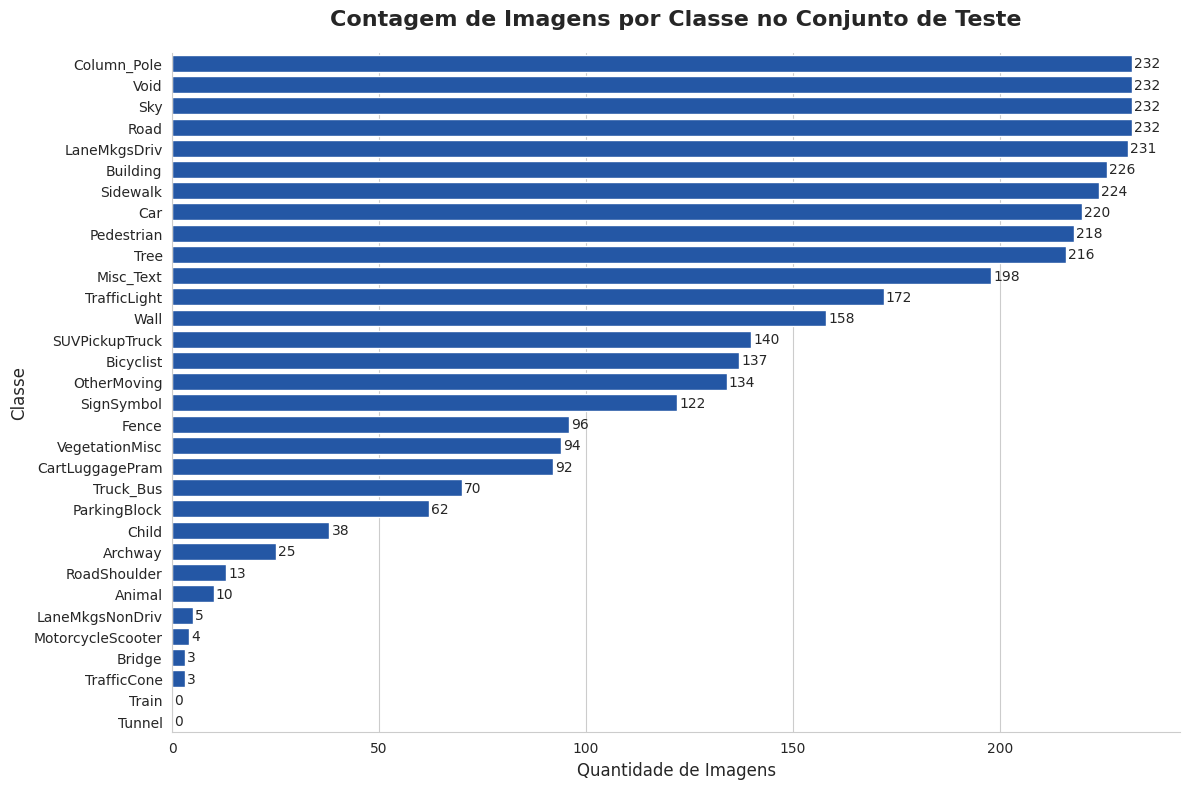

In [17]:
df_ranking_images = pd.DataFrame(list(class_image_counts.items()), columns=['Classe', 'Número de Imagens'])
# Ordenando os dados para a visualização no gráfico
df_plot = df_ranking_images.sort_values(by='Número de Imagens', ascending=False)

# Configurações do estilo e tamanho do gráfico
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# Criação do gráfico de barras horizontais
ax = sns.barplot(x='Número de Imagens', y='Classe', data=df_plot, color='#0F52BA', orient='h')

# ---- INÍCIO DO BLOCO CORRIGIDO ----
# As linhas abaixo devem estar no mesmo nível de indentação que a linha 'ax = sns.barplot(...)'

# Adicionando Título e Rótulos
ax.set_title('Contagem de Imagens por Classe no Conjunto de Teste', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Quantidade de Imagens', fontsize=12)
ax.set_ylabel('Classe', fontsize=12)

# Adicionando os valores exatos ao lado de cada barra
for p in ax.patches:

  width = p.get_width()
  ax.text(width + 0.5,
  p.get_y() + p.get_height() / 2.,
  f'{int(width)}',
  ha='left',
  va='center',
  fontsize=10)

# Removendo as bordas superior e direita do gráfico para um visual mais limpo
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustando o layout e exibindo o gráfico
plt.tight_layout()
plt.show()

##Investigação das duplicatas por MD5 olhando todos os metadados

In [19]:
def hash_file(filepath):
    """Calculates the MD5 hash of a file."""
    hasher = hashlib.md5()
    with open(filepath, 'rb') as f:
        while chunk := f.read(4096):
            hasher.update(chunk)
    return hasher.hexdigest()

def find_exact_duplicate_images(directory):
    """Finds exact duplicate images in a directory using cryptographic hashing."""
    hashes = {}
    duplicates = []

    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isdir(filepath):
            continue  # Skip directories
        try:
            file_hash = hash_file(filepath)
            if file_hash in hashes:
                duplicates.append((hashes[file_hash], filepath))
            else:
                hashes[file_hash] = filepath
        except Exception as e:
            print(f"Erro ao processar o arquivo {filepath}: {e}")

    return duplicates

# Directories to check for exact duplicates
image_directories_to_check = [
    dir_test,
    dir_train,
    dir_val,
    dir_test_labels,
    dir_train_labels,
    dir_val_labels
]

all_exact_duplicates = []
print("Verificando imagens duplicadas exatas:")
for directory in image_directories_to_check:
    print(f"Verificando diretório: {directory}")
    exact_duplicates_in_dir = find_exact_duplicate_images(directory)
    all_exact_duplicates.extend(exact_duplicates_in_dir)

if all_exact_duplicates:
    print("\nImagens duplicadas exatas encontradas:")
    df_exact_duplicates = pd.DataFrame(all_exact_duplicates, columns=['Imagem 1', 'Imagem 2'])
    display(df_exact_duplicates)
else:
    print("\nNão foram encontradas imagens duplicadas exatas em nenhum dos diretórios.")

Verificando imagens duplicadas exatas:
Verificando diretório: /content/camvid/CamVid/test
Verificando diretório: /content/camvid/CamVid/train
Verificando diretório: /content/camvid/CamVid/val
Verificando diretório: /content/camvid/CamVid/test_labels
Verificando diretório: /content/camvid/CamVid/train_labels
Verificando diretório: /content/camvid/CamVid/val_labels

Não foram encontradas imagens duplicadas exatas em nenhum dos diretórios.


##Investigação de Duplicatas por SHA256 olhando somente para os pixeis da imagem

In [20]:
def hash_image_pixels(filepath):
    """Calculates the SHA256 hash of the pixel content of an image."""
    try:
        with Image.open(filepath) as img:
            # Use ImageOps.exif_transpose to handle image orientation
            img = ImageOps.exif_transpose(img)
            # Convert to RGB to ensure consistent channel order and number
            img = img.convert('RGB')
            # Get pixel data as bytes
            img_bytes = np.array(img).tobytes()
            # Calculate SHA256 hash
            hasher = hashlib.sha256()
            hasher.update(img_bytes)
            return hasher.hexdigest()
    except Exception as e:
        print(f"Erro ao processar a imagem {filepath}: {e}")
        return None

def find_exact_pixel_duplicates(root_dir):
    """Finds exact duplicate PNG images based on pixel content recursively."""
    hash_to_filepaths = defaultdict(list)
    print(f"Scanning directory: {root_dir}")

    for root, _, files in os.walk(root_dir):
        for filename in files:
            if filename.lower().endswith('.png'):
                filepath = os.path.join(root, filename)
                img_hash = hash_image_pixels(filepath)
                if img_hash:
                    hash_to_filepaths[img_hash].append(filepath)

    duplicate_pairs = []
    for filepaths in hash_to_filepaths.values():
        if len(filepaths) > 1:
            # Generate unique pairs for files with the same hash
            for i in range(len(filepaths)):
                for j in range(i + 1, len(filepaths)):
                    filepath1 = filepaths[i]
                    filepath2 = filepaths[j]

                    # Determine the 'pasta' name
                    pasta1 = "other"
                    for special_folder in ["train", "test", "val"]:
                        if f"/{special_folder}/" in filepath1:
                            pasta1 = special_folder
                            break
                    if pasta1 == "other":
                         pasta1 = os.path.basename(os.path.dirname(filepath1))


                    duplicate_pairs.append({
                        'pasta': pasta1,
                        'Imagem 1': os.path.basename(filepath1),
                        'Imagem 2': os.path.basename(filepath2)
                    })

    return duplicate_pairs

# Specify the root directory to scan (replace with your dataset path)
root_directory = "/content/camvid/CamVid"

duplicate_results = find_exact_pixel_duplicates(root_directory)

if duplicate_results:
    print("\nExact duplicate images found based on pixel content:")
    df_duplicates_pixel = pd.DataFrame(duplicate_results)

    # Sort the DataFrame
    df_duplicates_pixel = df_duplicates_pixel.sort_values(by=['pasta', 'Imagem 1', 'Imagem 2'], ascending=[True, True, True])

    display(df_duplicates_pixel)

    # Optional: Save to CSV
    # csv_output_path = "pixel_duplicates.csv"
    # df_duplicates_pixel.to_csv(csv_output_path, index=False)
    # print(f"\nDuplicate results saved to {csv_output_path}")

else:
    print("\nNão foram encontradas imagens duplicadas exatas em nenhum dos diretórios..")

Scanning directory: /content/camvid/CamVid

Não foram encontradas imagens duplicadas exatas em nenhum dos diretórios..


##Investigação de duplicatas por pHash

---



In [21]:
def find_duplicate_images(directory, threshold_percentage=98):
    hashes = {}
    similar_images = []

    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isdir(filepath):
            continue  # Skip directories
        try:
            with Image.open(filepath) as img:
                img_hash = imagehash.phash(img)
                for existing_filepath, existing_hash in hashes.items():
                     # Calculate Hamming distance
                    hamming_distance = img_hash - existing_hash

                    # Calculate similarity percentage
                    # phash typically uses a hash size of 8x8=64 bits.
                    max_distance = 64
                    similarity_percentage = ((max_distance - hamming_distance) / max_distance) * 100

                    if similarity_percentage >= threshold_percentage:
                         similar_images.append({
                             'Imagem 1': os.path.basename(existing_filepath), # Extract only filename
                             'Imagem 2': os.path.basename(filepath), # Extract only filename
                             'Similaridade (%)': similarity_percentage,
                             'Nome_Pasta': os.path.basename(directory)
                             })

                hashes[filepath] = img_hash # Add the current image hash to the dictionary

        except Exception as e:
            print(f"Erro ao processar a imagem {filepath}: {e}")

    return similar_images

# Directories to check for duplicates
image_directories_to_check = [
    dir_test,
    dir_train,
    dir_val,
]

all_duplicates = []
print("Verificando imagens similares:")
for directory in image_directories_to_check:
    print(f"Verificando diretório: {directory}")
    duplicates_in_dir = find_duplicate_images(directory, threshold_percentage=100)
    all_duplicates.extend(duplicates_in_dir)

if all_duplicates:
    print("\nImagens muito similares (>= 100% de similaridade) foram encontradas:")
    df_duplicates = pd.DataFrame(all_duplicates)
    # Reorder columns
    df_duplicates = df_duplicates[['Nome_Pasta', 'Imagem 1', 'Imagem 2', 'Similaridade (%)']]
    display(df_duplicates)
else:
    print("\nNão foram encontradas imagens muito similares (>= 100% de similaridade) em nenhum dos diretórios.")

Verificando imagens similares:
Verificando diretório: /content/camvid/CamVid/test
Verificando diretório: /content/camvid/CamVid/train
Verificando diretório: /content/camvid/CamVid/val

Imagens muito similares (>= 100% de similaridade) foram encontradas:


,Nome_Pasta,Imagem 1,Imagem 2,Similaridade (%)
0,test,0001TP_009330.png,0001TP_009360.png,100.0
1,test,Seq05VD_f02010.png,Seq05VD_f02070.png,100.0
2,test,0016E5_04440.png,0016E5_04500.png,100.0
3,test,Seq05VD_f02010.png,Seq05VD_f02610.png,100.0
4,test,Seq05VD_f02070.png,Seq05VD_f02610.png,100.0
...,...,...,...,...
71,val,0001TP_009270.png,0001TP_009300.png,100.0
72,val,Seq05VD_f02280.png,Seq05VD_f02310.png,100.0
73,val,Seq05VD_f02280.png,Seq05VD_f02340.png,100.0
74,val,Seq05VD_f02310.png,Seq05VD_f02340.png,100.0


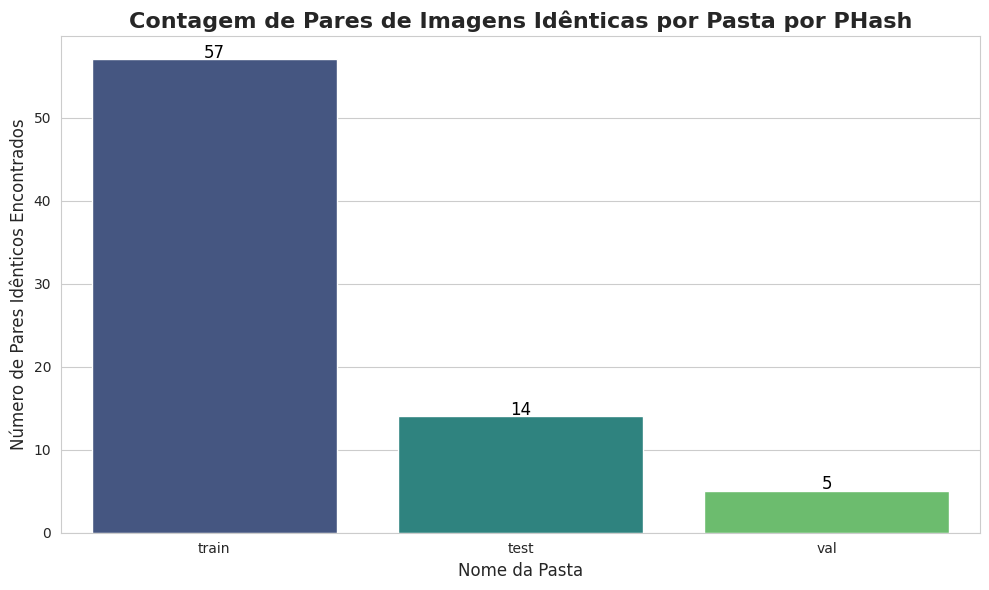

In [23]:
# Verifique se o DataFrame de duplicatas não está vazio
if not df_duplicates.empty:
    # Contar o número de pares duplicados encontrados em cada pasta
    contagem_por_pasta = df_duplicates['Nome_Pasta'].value_counts()

    # Criar o gráfico
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=contagem_por_pasta.index, y=contagem_por_pasta.values, palette='viridis', hue=contagem_por_pasta.index, legend=False)

    # Adicionar Título e Rótulos
    plt.title('Contagem de Pares de Imagens Idênticas por Pasta por PHash', fontsize=16, fontweight='bold')
    plt.xlabel('Nome da Pasta', fontsize=12)
    plt.ylabel('Número de Pares Idênticos Encontrados', fontsize=12)
    plt.xticks(rotation=0) # Mantém os nomes das pastas na horizontal

    # Adicionar os valores exatos no topo de cada barra
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    fontsize=12, color='black',
                    xytext=(0, 5),
                    textcoords='offset points')

    plt.tight_layout()
    plt.show()
else:
    print("Nenhuma duplicata encontrada para plotar o gráfico.")